In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
party_the_3rd = os.path.join(parent, 'third_party')
for path_ in [parent, party_the_3rd]:
    if path_ not in (cur_path:=sys.path):
        sys.path = [path_] + cur_path
print(sys.path)


import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import kradagrad
import shampoo


['/home/jmei/code/experiments/kradagrad/third_party', '/home/jmei/code/experiments/kradagrad', '/home/jmei/code/experiments/kradagrad/experiments', '/home/jmei/miniconda3/envs/krad/lib/python310.zip', '/home/jmei/miniconda3/envs/krad/lib/python3.10', '/home/jmei/miniconda3/envs/krad/lib/python3.10/lib-dynload', '', '/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages']


/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# problem sizes
X_sz = 4
Y_sz = 2
batch_sz = 32
N_tr = 1_024
N_va = 128

# model hyperparams
mlp_sizes = [X_sz, 8, 8, Y_sz]
loss_fn = torch.nn.MSELoss()

# reproducible
torch.manual_seed(4750)

# create MLP
layers = []
for i_ in range(1, len(mlp_sizes)):
    layers.append(torch.nn.Linear(mlp_sizes[i_ - 1], mlp_sizes[i_]))
    layers.append(torch.nn.Softplus())
model = torch.nn.Sequential(*layers[:-1])

#we don't really need gt params for anything:
#params_gt = list(x.detach() for x in model.parameters())

# gen data
# non-diagonal data distribution
U = torch.randn((X_sz, X_sz))
U = torch.triu(U)

X = torch.randn((N_tr+N_va, X_sz)).mm(U.T)
Y = model(X)

dataloader_tr = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[:N_tr], Y[:N_tr]), batch_size=batch_sz, shuffle=True)
dataloader_va = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[N_tr:], Y[N_tr:]), batch_size=batch_sz, shuffle=True)

In [3]:
# re-intialize params for fair training
def reinit(model, seed):
    torch.manual_seed(seed)
    for p in model.parameters():
        with torch.no_grad():
            p.data = torch.randn_like(p)
            
# repeatable training run for different optimizers
def simple_train_run(model, loss_fn, n_it, opt, val_int, retain_graph=False, dataloader_tr=dataloader_tr, dataloader_va=dataloader_va):
    n_tr = len(dataloader_tr.dataset)
    n_va = len(dataloader_va.dataset)
    model.train()
    loss_tr = []
    loss_va = []
    for it_ in tqdm(range(n_it), 'Epoch'):
        loss_tr_this = 0
        for i_, (X_b, Y_b) in enumerate(dataloader_tr):
            Y_hat = model(X_b)
            err = loss_fn(Y_hat, Y_b)
            with torch.no_grad():
                loss_tr_this += err.item()
            opt.zero_grad()
            err.backward(retain_graph=retain_graph)
            opt.step()
        loss_tr.append(loss_tr_this / n_tr)
        
        # validation loss
        if it_ % val_int == (val_int - 1):
            model.eval()
            loss_va_this = 0
            for i_, (X_b, Y_b) in enumerate(dataloader_va):
                with torch.no_grad():
                    Y_hat = model(X_b)
                    err = loss_fn(Y_hat, Y_b)
                    loss_va_this += err.item()
            loss_va.append(loss_va_this / n_va)
            model.train()
    return loss_tr, loss_va

In [4]:
# common optimizer hyperparams
lr = 5e-3
seed_exp = 95054

# training settings
n_it = 320
val_int = 4
it_val = [x for x in range(n_it) if x % val_int == val_int - 1]


# Optimizers
opt_names = ['sgd', 'ada', 'shampoo', 'shampoo ONS', 'krad', 'krad ONS']
loss_tr = {}
loss_va = {}
hps = [shampoo.ShampooHyperParams(matrix_eps=m_, graft_type=g_, block_size=b_, inverse_exponent_override=i_) for (m_, g_, b_, i_) in (
    
    [1e-2, 1, np.inf, 0],  # SGD
    [1e-2, 2, np.inf, 0],  # Adagrad
    [1e-6, 0, 8, 0],          # Shampoo
    [1e-6, 0, 8, 2],          # Shampoo ONS

    [1e0, 0, 8, 0],            # Krad
    [1e0, 0, 8, 2],            # Krad ONS
)]

classes = [shampoo.Shampoo] * 4 + [kradagrad.KradagradPP] * 2

opts = [class_(model.parameters(), lr=lr, hyperparams=hp_) for (class_, hp_) in zip(classes, hps)]

for opt_name_, opt_ in zip(opt_names, opts):
    print('Using {}'.format(opt_name_))
    reinit(model, seed_exp)
    # `retain_graph` still required for some reason... haven't figured out why
    loss_tr_, loss_va_ = simple_train_run(model, loss_fn, n_it, opt_, val_int, retain_graph=True)
    loss_tr[opt_name_] = loss_tr_
    loss_va[opt_name_] = loss_va_


Using sgd


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:11<00:00, 26.84it/s]


Using ada


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:12<00:00, 25.35it/s]


Using shampoo


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:18<00:00, 17.03it/s]


Using shampoo ONS


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:19<00:00, 16.82it/s]


Using krad


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:20<00:00, 15.69it/s]


Using krad ONS


Epoch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [00:20<00:00, 15.53it/s]


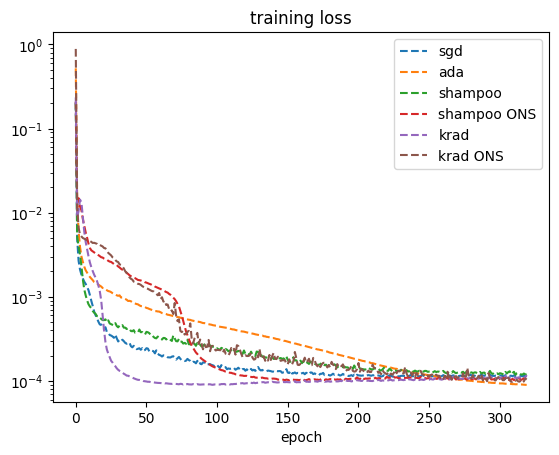

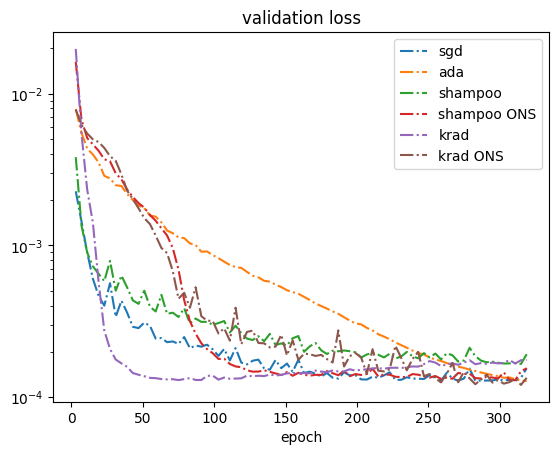

In [7]:
plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(range(n_it), loss_tr[opt_name_], '--')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('training loss')

plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(it_val, loss_va[opt_name_], '-.')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('validation loss')

plt.show()